In [1]:
#sys path
from sys import path
from pathlib import Path

module_path = str(Path.cwd().parents[0])

if module_path not in path:
    path.append(module_path)
    
path.append(module_path + '\\functions')


# libraries
import pandas as pd
import numpy as np
import casadi as ca
import scipy.linalg
import matplotlib.pyplot as plt

from gp_regression import GPR
import save_outputs
import time

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Import model, inputs and outputs

In [2]:
gp = GPR.load_model('models/IEEE9')

In [3]:
input_dict = save_outputs.load_model('IEEE9 - pandapower\inputs\IEEE9_TA1')

x_d = np.array(input_dict['xd'])
xd_std = np.array(input_dict['xd_std'])
u = np.array(input_dict['u'])

In [4]:
# TA1
TA1_dict = save_outputs.load_model('outputs\IEEE9_TA1')

x_TA1 = np.array(TA1_dict['x'])
s_TA1 = np.array(TA1_dict['s'])


# TA2
TA2_dict = save_outputs.load_model('outputs\IEEE9_TA2')

x_TA2 = np.array(TA2_dict['x'])
s_TA2 = np.array(TA2_dict['s'])


# EM
EM_dict = save_outputs.load_model('outputs\IEEE9_EM')

x_EM = np.array(EM_dict['x'])
s_EM = np.array(EM_dict['s'])

# Monte Carlo

## 1. Power Flow 

### a) Mean value

In [5]:
# Data Set

df_pf_mean = pd.read_csv('datasets\dataset_tested_real.csv')
df_pf_mean

,Unnamed: 0,Pg0,Pg1,Pg2,Load_P1,Load_P2,Load_P3,Load_Q1,Load_Q2,Load_Q3,RS_P1,RS_P2,RS_Q1,RS_Q2,P0,P1,P2,P3,P4,P5,P6,P7,P8,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,U0,U1,U2,U3,U4,U5,U6,U7,U8,Ud0,Ud2,Ud2.1,Ud3,Ud4,Ud5,Ud6,Ud7,Ud8,P_03,P_34,P_45,P_25,P_56,P_67,P_71,P_78,P_83
0,0,61.502445,101.94434,71.553215,90.0,100.0,125.0,30.0,35.0,50.0,50.0,30.0,15.0,10.0,-64.849116,-101.94434,-71.553215,-50.0,90.0,-30.0,100.0,0.0,125.0,-3.381189,-1.954189,16.785059,-15.0,30.0,-10.0,35.0,0.0,50.0,1.0,1.0,1.0,0.998751,0.986995,1.010706,0.991671,1.000809,0.970411,0.0,2.971153,2.690221,-2.14335,-4.353747,0.312565,-2.629351,-0.678978,-5.627862,64.849116,42.384469,-47.927282,71.553215,52.706058,-47.640953,-101.94434,54.10393,-71.86577


In [6]:
def _get_outputs(df):
    V = df[['U3','U4','U5', 'U6', 'U7', 'U8', 'Q0','Q1', 'Q2',
             'P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']]
    return V 


out_pf_mean = _get_outputs(df_pf_mean)


out_pf_mean[['U3','U4','U5', 'U6', 'U7', 'U8']] = out_pf_mean[['U3','U4','U5', 'U6', 'U7', 'U8']]*345

out_pf_mean = np.array(out_pf_mean)
out_pf_mean.shape

(1, 15)

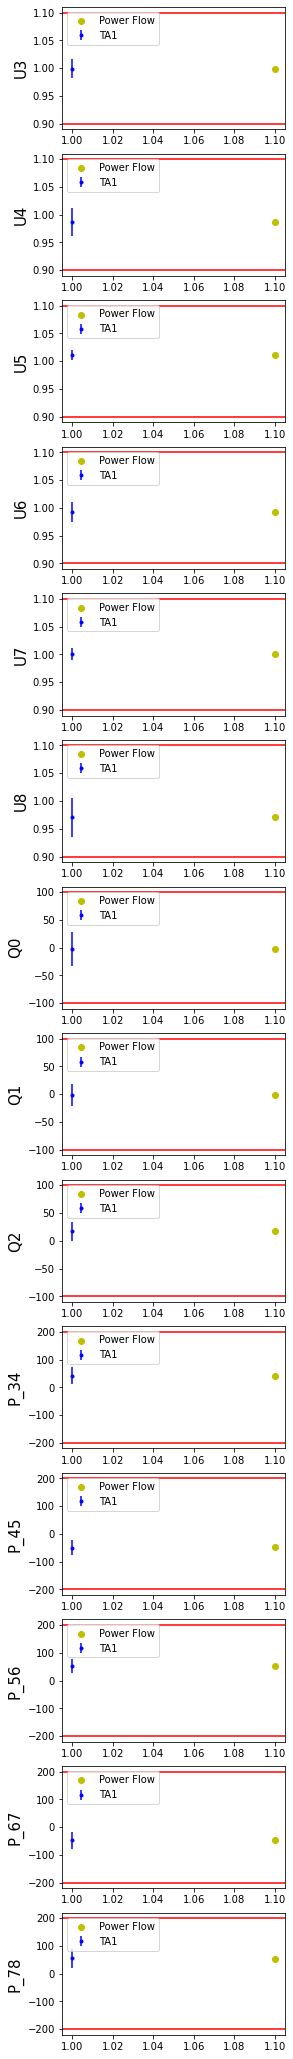

In [7]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

m = x_d.shape[0]

t1 = np.arange(1,m+1)
t2 = np.arange(1,m+1)+0.1

x_names = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8', 'Q0', 'Q1', 'Q2',
           'P_34', 'P_45', 'P_56', 'P_67', 'P_78', 'P_83']
u_names = ['Pg0', 'Pg1', 'Pg2']
d_names = ['Load1', 'Load2', 'Load3', 'RS1', 'RS2']

fig_x = plt.figure(figsize=(4, 40))
for i in range(x_TA1.shape[1]-1):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
        
        
            if i<6:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_mean[:, i]/345, color='y', label='Power Flow')
                
                ax.axhline(y=1.1, xmin=0, xmax=10, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=10, color='r')
                
            elif i>5 and i<9:
                ax.errorbar(t1, x_TA1[:, i], yerr=  3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')

                
                ax.scatter(t2, out_pf_mean[:, i], color='y', label='Power Flow')
                
                ax.axhline(y=100,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-100, xmin=0, xmax=10, color='r')
                
            else:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_mean[:, i], color='y', label='Power Flow')
                
                ax.axhline(y=200,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-200, xmin=0, xmax=10, color='r')
                
        
            plt.legend(loc='upper left')
            ax.set_ylabel(x_names[i], fontsize=15)   

### b) Uncertanty

In [8]:
# Data Set

df_pf_uncertanty = pd.read_csv('datasets\dataset_tested_uncertain.csv')
df_pf_uncertanty.head()

,Unnamed: 0,Pg0,Pg1,Pg2,Load_P1,Load_P2,Load_P3,Load_Q1,Load_Q2,Load_Q3,RS_P1,RS_P2,RS_Q1,RS_Q2,P0,P1,P2,P3,P4,P5,P6,P7,P8,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,U0,U1,U2,U3,U4,U5,U6,U7,U8,Ud0,Ud2,Ud2.1,Ud3,Ud4,Ud5,Ud6,Ud7,Ud8,P_03,P_34,P_45,P_25,P_56,P_67,P_71,P_78,P_83
0,0,46.337413,82.319006,57.935636,75.343987,104.781453,101.731819,25.114662,36.673508,40.692727,59.075642,36.189561,17.722693,12.063187,-48.591842,-82.319006,-57.935636,-59.075642,75.343987,-36.189561,104.781453,0.0,101.731819,12.870266,4.613841,22.965382,-17.722693,25.114662,-12.063187,36.673508,0.0,40.692727,1.0,1.0,1.0,1.007802,1.000078,1.014026,0.994049,1.004202,0.986954,0.0,1.339649,1.659348,-1.591436,-3.679866,-0.259312,-3.499362,-1.597132,-4.787049,48.591842,40.246655,-35.368963,57.935636,58.268067,-46.931716,-82.319006,35.192704,-66.939195
1,1,63.200126,104.141339,73.077664,103.464164,122.666558,119.132248,34.488055,42.933295,47.652899,66.852172,37.991669,20.055652,12.663890,-66.791030,-104.141339,-73.077664,-66.852172,103.464164,-37.991669,122.666558,0.0,119.132248,-1.164817,-6.288599,12.936575,-20.055652,34.488055,-12.663890,42.933295,0.0,47.652899,1.0,1.0,1.0,1.000069,0.982336,1.008490,0.984027,0.998194,0.972981,0.0,1.927645,1.757592,-2.204653,-5.193404,-0.676090,-4.255349,-1.811042,-5.867315,66.791030,57.542185,-46.502115,73.077664,63.690456,-59.492421,-104.141339,44.327417,-75.458182
2,2,55.688388,94.420267,66.332430,93.820210,82.950598,109.082248,31.273403,29.032709,43.632899,38.836907,30.575063,11.651072,10.191688,-58.774114,-94.420267,-66.332430,-38.836907,93.820210,-30.575063,82.950598,0.0,109.082248,-1.035467,5.019785,20.943661,-11.651072,31.273403,-10.191688,29.032709,0.0,43.632899,1.0,1.0,1.0,0.999977,0.987056,1.013019,0.998845,1.004872,0.978215,0.0,3.674093,3.257425,-1.940101,-4.077262,1.058375,-1.329200,0.307371,-4.624550,58.774114,41.330724,-52.788596,66.332430,43.003274,-40.173457,-94.420267,54.108518,-55.922557
3,3,69.913076,112.828686,79.105619,69.665021,109.636899,169.586611,23.221674,38.372915,67.834644,51.535737,35.505412,15.460721,11.835137,-74.597199,-112.828686,-79.105619,-51.535737,69.665021,-35.505412,109.636899,0.0,169.586611,-16.397416,-13.647974,14.563634,-15.460721,23.221674,-11.835137,38.372915,0.0,67.834644,1.0,1.0,1.0,0.991487,0.988739,1.009599,0.984814,0.993975,0.945411,0.0,2.941840,3.479392,-2.483801,-3.730567,0.847722,-2.914815,-1.126449,-7.568283,74.597199,22.993724,-46.762914,79.105619,66.975653,-43.227284,-112.828686,69.433626,-101.842310
4,4,61.218461,101.576832,71.298210,82.188897,83.081774,137.328137,27.396299,29.078621,54.931255,50.557530,17.947773,15.167259,5.982591,-64.605860,-101.576832,-71.298210,-50.557530,82.188897,-17.947773,83.081774,0.0,137.328137,-5.121641,-0.659994,17.054437,-15.167259,27.396299,-5.982591,29.078621,0.0,54.931255,1.0,1.0,1.0,0.997744,0.989223,1.010858,0.995936,1.001602,0.965204,0.0,3.284812,2.737629,-2.137463,-4.072527,0.368806,-2.013316,-0.349260,-5.916585,64.605860,36.790061,-45.631567,71.298210,42.784502,-40.523972,-101.576832,60.911611,-77.657018


In [9]:
def _get_outputs(df):
    V = df[['U3','U4','U5', 'U6', 'U7', 'U8', 
            'Q0', 'Q1', 'Q2',
            'P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']]
    return V 


out_pf_uncertanty = _get_outputs(df_pf_uncertanty)


out_pf_uncertanty[['U3','U4','U5', 'U6', 'U7', 'U8']] = out_pf_uncertanty[['U3','U4','U5', 'U6', 'U7', 'U8']]*345

out_pf_uncertanty = np.array(out_pf_uncertanty)
out_pf_uncertanty.shape

(5000, 15)

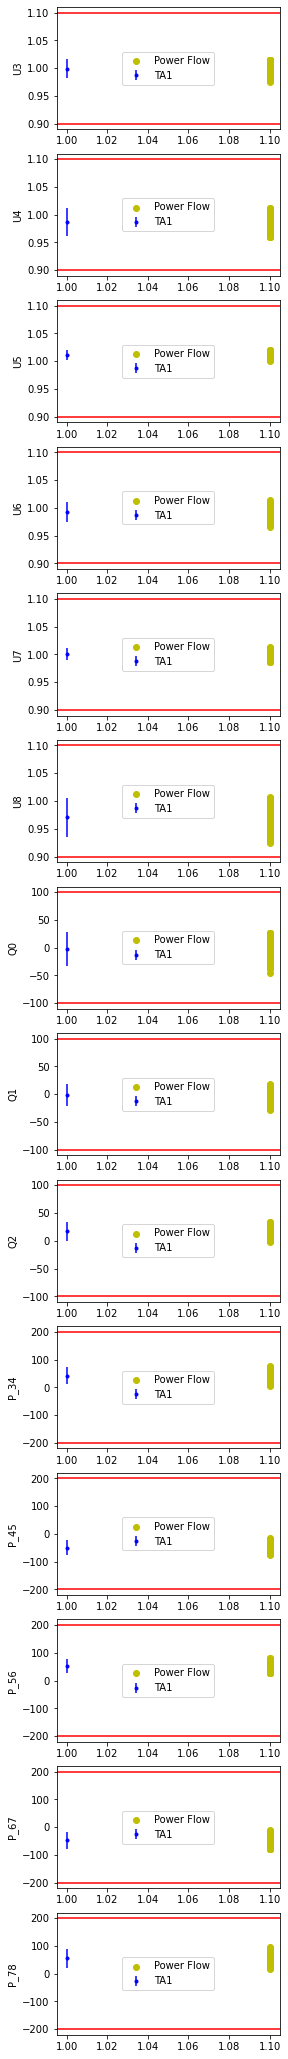

In [10]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

m = x_d.shape[0]

t1 = np.arange(1,m+1)
t2 = np.ones(5000) * 1.1 

x_names = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8','Q0', 'Q1', 'Q2',
          'P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']
u_names = ['Pg0','Pg1', 'Pg2']
d_names = ['Load1', 'Load2', 'Load3', 'RS1', 'RS2']

fig_x = plt.figure(figsize=(4, 40))
for i in range(x_TA1.shape[1]-1):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
            
            if i<6:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i]/345, color='y', label='Power Flow')
                
                ax.axhline(y=1.1, xmin=0, xmax=10, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=10, color='r')
                
            elif i>5 and i<9:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='Power Flow')
                
                ax.axhline(y=100,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-100, xmin=0, xmax=10, color='r')
                            
            else:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='Power Flow')
                
                ax.axhline(y=200,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-200, xmin=0, xmax=10, color='r')
    

            
            plt.legend(loc='best')
            ax.set_ylabel(x_names[i])

## 2. GP 

### a) Mean value

In [11]:
P_cont = u
X_d = x_d
X_input = np.concatenate((P_cont, X_d), axis=1)

In [12]:
mean_pred = gp.predict_gp_mean(X_input)
out_gp_mean = np.array(mean_pred).reshape(1,-1)

out_gp_mean.shape

(1, 15)

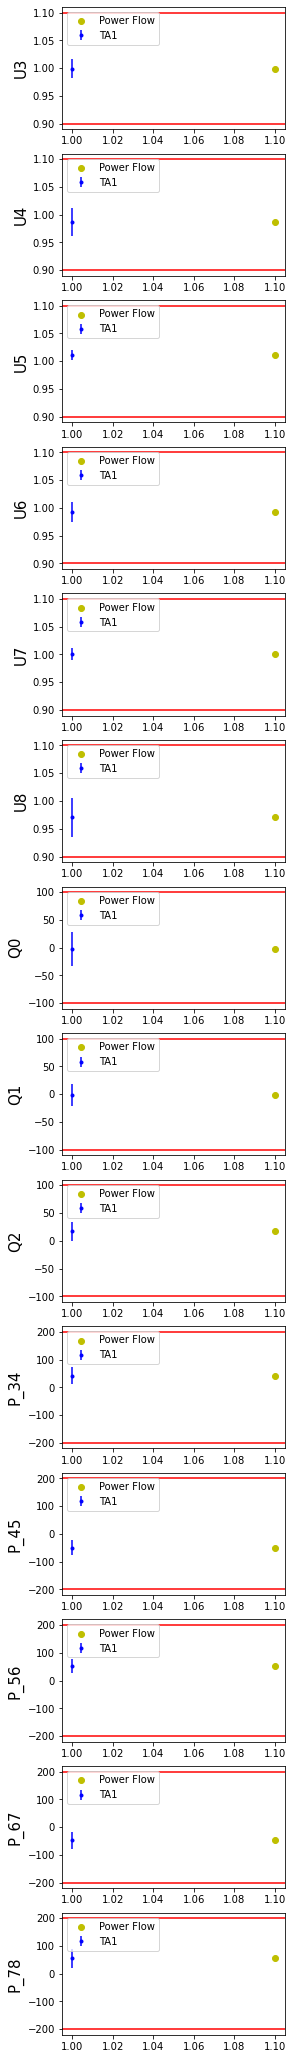

In [13]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))


t1 = np.arange(1,2)
t2 = np.arange(1,2) + 0.1 

x_names = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8', 'Q0', 'Q1', 'Q2',
          'P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']
u_names = ['Pg0', 'Pg1', 'Pg2']
d_names = ['Load1', 'Load2', 'Load3', 'RS1', 'RS2']

fig_x = plt.figure(figsize=(4, 40))
for i in range(x_TA1.shape[1]-1):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
        
        
            if i<6:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_gp_mean[:, i]/345, color='y', label='Power Flow')
                
                ax.axhline(y=1.1, xmin=0, xmax=10, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=10, color='r')
                
            elif i>5 and i<9:
                ax.errorbar(t1, x_TA1[:, i], yerr=  3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')

                
                ax.scatter(t2, out_gp_mean[:, i], color='y', label='Power Flow')
                
                ax.axhline(y=100,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-100, xmin=0, xmax=10, color='r')
                
            else:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_gp_mean[:, i], color='y', label='Power Flow')
                
                ax.axhline(y=200,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-200, xmin=0, xmax=10, color='r')

            
            plt.legend(loc='upper left')
            ax.set_ylabel(x_names[i], fontsize=15)
            

### b) Uncertanty

In [14]:
P_cont = u
input_mean = x_d
input_std = np.sqrt(xd_std)

In [15]:
X_GP = df_pf_uncertanty.loc[:,['Pg0', 'Pg1', 'Pg2', 'Load_P1', 'Load_P2','Load_P3','RS_P1', 'RS_P2']] 
X_GP = np.array(X_GP)
X_GP.shape

(5000, 8)

In [16]:
gp_prediction_uncertanty = []

t = -time.time()
for i in range(X_GP.shape[0]):
    mean_pred = gp.predict_gp_mean(X_GP[i,:].reshape(1,-1))
    a = np.array(mean_pred).reshape(1,-1).tolist()[0]
    gp_prediction_uncertanty.append(a)
    
t += time.time()

print('Time of solver:', t)

out_gp_uncertanty = np.array(gp_prediction_uncertanty)
out_gp_uncertanty.shape

Time of solver: 137.3249795436859


(5000, 15)

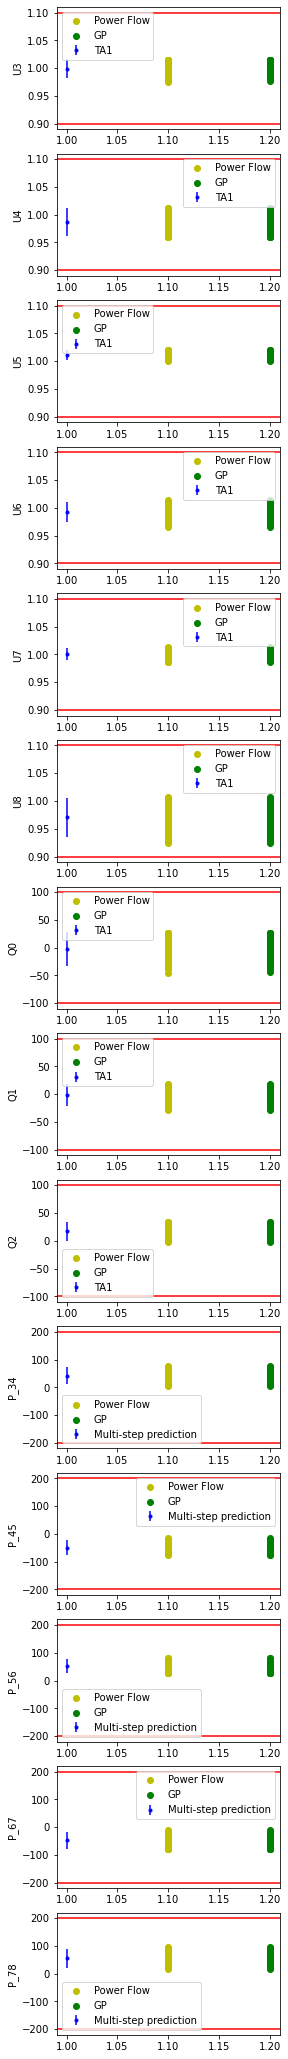

In [17]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

t1 = np.arange(1,2)
t2 = np.ones(5000) + 0.1 
t3 = np.ones(5000) + 0.2

x_names = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8','Q0', 'Q1', 'Q2',
          'P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']
u_names = ['Pg0','Pg1', 'Pg2']
d_names = ['Load1', 'Load2', 'Load3', 'Wind1', 'Wind2']

fig_x = plt.figure(figsize=(4, 40))
for i in range(x_TA1.shape[1]-1):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
            
            if i<6:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i]/345, color='y', label='Power Flow')
                ax.scatter(t3, out_gp_uncertanty[:, i]/345, color='g', label='GP')
                
                ax.axhline(y=1.1, xmin=0, xmax=10, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=10, color='r')
                
            elif i>5 and i<9:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='Power Flow')
                ax.scatter(t3, out_gp_uncertanty[:, i], color='g', label='GP')
                
                ax.axhline(y=100,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-100, xmin=0, xmax=10, color='r')
                            
            else:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='Multi-step prediction')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='Power Flow')
                ax.scatter(t3, out_gp_uncertanty[:, i], color='g', label='GP')
                
                ax.axhline(y=200,  xmin=0, xmax=10, color='r')
                ax.axhline(y=-200, xmin=0, xmax=10, color='r')
    

            
            plt.legend(loc='best')
            ax.set_ylabel(x_names[i])

------------

#  Monte Carlo (PF and GP) vs analitical GP 

In [18]:
def MonteCarlo(df, num_of_labels, num_of_points, num_of_sampl=5000, name='PF'):
    
    lb = []
    ub = []
    for i in range(num_of_labels):
        for j in range(num_of_points):
            
            if name == 'PF':
                data = out_pf_uncertanty[j*num_of_sampl:(j+1)*num_of_sampl,i]
            elif name == 'GP':
                data = out_gp_uncertanty[j*num_of_sampl:(j+1)*num_of_sampl,i]
                
            lb_5 = np.percentile(data, 0.27)
            ub_95 = np.percentile(data, 99.73)
            
            #lb_5 = np.percentile(data,  5)
            #ub_95 = np.percentile(data, 95.)
            
            lb.append(lb_5)
            ub.append(ub_95)
            
    return np.array(lb), np.array(ub)

In [19]:
# GP

#mean
g = []
for i in range(out_gp_mean.shape[1]):
    for j in range(out_gp_mean.shape[0]):
        g.append(out_gp_mean[j, i])
        
#margins
l_q, u_q = MonteCarlo(out_gp_uncertanty, 15, 1, num_of_sampl=5000, name='GP')

lb_q = l_q.reshape(1, 15)
ub_q = u_q.reshape(1, 15)

lb_q = g - lb_q
ub_q = ub_q - g

bound_q = np.concatenate((lb_q, ub_q), axis=0)
bound_q.shape

(2, 15)

In [20]:
# Power Flow

#mean
m = []
for i in range(out_pf_mean.shape[1]):
    for j in range(out_pf_mean.shape[0]):
        m.append(out_pf_mean[j, i])
        
#margins        
l, u = MonteCarlo(out_pf_uncertanty, 15, 1, num_of_sampl=5000, name='PF')

lb = l.reshape(1, 15)
ub = u.reshape(1, 15)

lb = m - lb
ub = ub - m

bound = np.concatenate((lb, ub), axis=0)
bound.shape

(2, 15)

-----------

# Uncertanty estimation

In [21]:
num=3

pred_uncertanty_TA1 = num * np.sqrt(s_TA1[0, :])
pred_uncertanty_TA1[:6] = pred_uncertanty_TA1[:6]/345
pred_uncertanty_TA1[6:] = pred_uncertanty_TA1[6:]/100

pred_uncertanty_TA2 = num * np.sqrt(s_TA2[0, :])
pred_uncertanty_TA2[:6] = pred_uncertanty_TA2[:6]/345
pred_uncertanty_TA2[6:] = pred_uncertanty_TA2[6:]/100

pred_uncertanty_EM = num  * np.sqrt(s_EM[0, :])
pred_uncertanty_EM[:6] = pred_uncertanty_EM[:6]/345
pred_uncertanty_EM[6:] = pred_uncertanty_EM[6:]/100

real_up_uncertanty = []
real_down_uncertanty = []
gp_up_uncertanty = []
gp_down_uncertanty = []

for i in range(15):
    real_up_uncertanty.append((bound[0, i:(i+1)][0]))
    real_down_uncertanty.append((bound[1, i:(i+1)][0]))
    gp_up_uncertanty.append((bound_q[0, i:(i+1)][0]))
    gp_down_uncertanty.append((bound_q[1, i:(i+1)][0]))
    
real_up_uncertanty = np.array(real_up_uncertanty)
real_down_uncertanty = np.array(real_down_uncertanty)

gp_up_uncertanty = np.array(gp_up_uncertanty)
gp_down_uncertanty = np.array(gp_down_uncertanty)

real_up_uncertanty[:6] = real_up_uncertanty[:6]/345
real_down_uncertanty[:6] = real_down_uncertanty[:6]/345
real_up_uncertanty[6:] = real_up_uncertanty[6:]/100
real_down_uncertanty[6:] = real_down_uncertanty[6:]/100

gp_up_uncertanty[:6] = gp_up_uncertanty[:6]/345
gp_down_uncertanty[:6] = gp_down_uncertanty[:6]/345
gp_up_uncertanty[6:] = gp_up_uncertanty[6:]/100
gp_down_uncertanty[6:] = gp_down_uncertanty[6:]/100

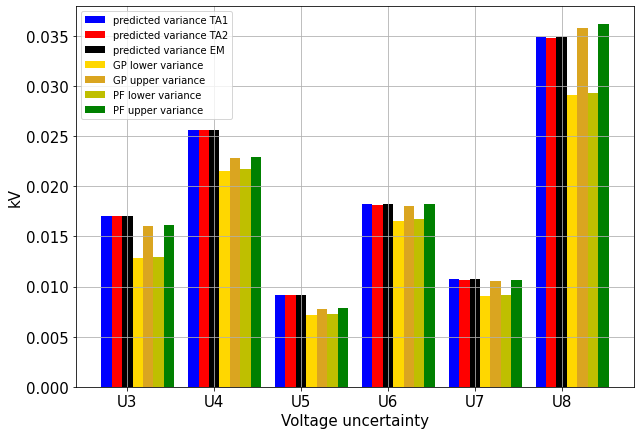

In [22]:
w=0.12
x = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8']


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(10,7))

plt.bar(bar1, pred_uncertanty_TA1[:6], w, label='predicted variance TA1', color='b')
plt.bar(bar2, pred_uncertanty_TA2[:6], w, label='predicted variance TA2', color='r')
plt.bar(bar3, pred_uncertanty_EM[:6], w, label='predicted variance EM', color='k')
plt.bar(bar4, gp_down_uncertanty[:6], w, label='GP lower variance', color='gold')
plt.bar(bar5, gp_up_uncertanty[:6], w, label='GP upper variance', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[:6], w, label='PF lower variance', color='y')
plt.bar(bar7, real_up_uncertanty[:6], w, label='PF upper variance', color='g')

plt.xticks(bar1 + 2*w, x)
plt.ylabel('kV', fontsize=15)
plt.xlabel('Voltage uncertainty', fontsize=15)
plt.legend()
plt.grid()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('figures/U_uncertanty_bar.png', bbox_inches = 'tight')

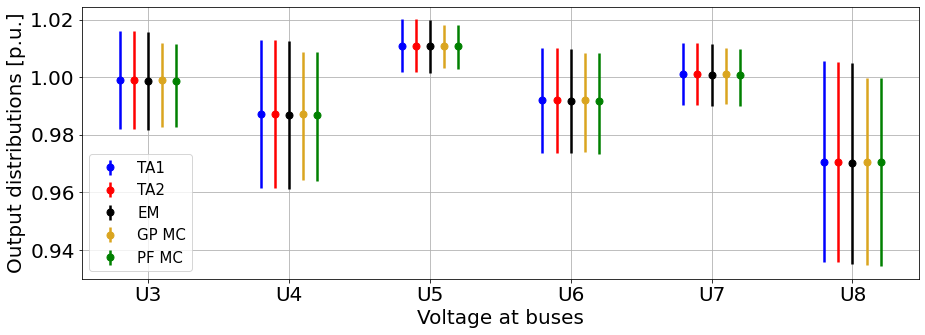

In [23]:
m=6
x = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8']


t = np.arange(1,m+1)-0.2
t1 = np.arange(1,m+1)-0.1
t2 = np.arange(1,m+1)
t3 = np.arange(1,m+1)+0.1
t4 = np.arange(1,m+1)+0.2

plt.figure(figsize=(15, 5))
plt.errorbar(t, x_TA1[:,:6].flatten()/345, yerr= 3 * np.sqrt(s_TA1[:,:6].flatten())/345, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='b', label='TA1')
plt.errorbar(t1, x_TA2[:,:6].flatten()/345, yerr= 3 * np.sqrt(s_TA2[:,:6].flatten())/345, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='r', label='TA2')
plt.errorbar(t2, x_EM[:,:6].flatten()/345, yerr= 3 * np.sqrt(s_EM[:,:6].flatten())/345, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='k', label='EM')

plt.errorbar(t3, out_gp_mean[:, :6].flatten()/345, yerr=bound_q[:, :6]/345, marker='.',
                        ms=14, lw=2.5, linestyle='None', color='goldenrod', label='GP MC')
plt.errorbar(t4, out_pf_mean[:, :6].flatten()/345, yerr=bound[:, :6]/345, marker='.',
                        ms=14, lw=2.5, linestyle='None', color='g', label='PF MC')

plt.grid()
plt.ylabel('Output distributions [p.u.]', fontsize=20)
plt.xlabel('Voltage at buses', fontsize=20)
plt.legend(fontsize=15, loc=3)
plt.xticks(t2, x, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
#plt.axis(ymin=-60,ymax=60)

plt.savefig('figures/U_uncertanty_error.png', bbox_inches = 'tight')

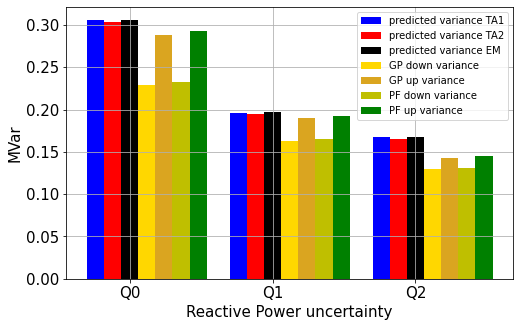

In [24]:
w=0.12
x = ['Q0', 'Q1', 'Q2']


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(8,5))

plt.bar(bar1, pred_uncertanty_TA1[6:9], w, label='predicted variance TA1', color='b')
plt.bar(bar2, pred_uncertanty_TA2[6:9], w, label='predicted variance TA2', color='r')
plt.bar(bar3, pred_uncertanty_EM[6:9], w, label='predicted variance EM', color='k')
plt.bar(bar4, gp_down_uncertanty[6:9], w, label='GP down variance', color='gold')
plt.bar(bar5, gp_up_uncertanty[6:9], w, label='GP up variance', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[6:9], w, label='PF down variance', color='y')
plt.bar(bar7, real_up_uncertanty[6:9], w, label='PF up variance', color='g')


plt.xticks(bar1 + 2*w, x)
plt.ylabel('MVar', fontsize=15)
plt.xlabel('Reactive Power uncertainty', fontsize=15)
plt.legend()
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('figures/Q_uncertanty_bar.png', bbox_inches = 'tight')

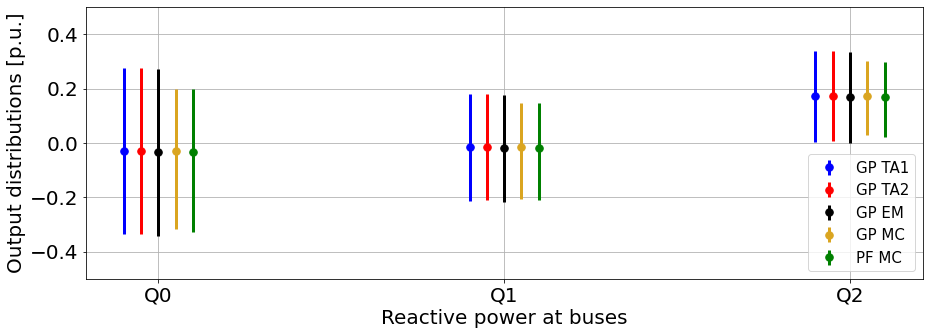

In [25]:
m=3
x = ['Q0', 'Q1', 'Q2']


t = np.arange(1,m+1)-0.1
t1 = np.arange(1,m+1)-0.05
t2 = np.arange(1,m+1)
t3 = np.arange(1,m+1)+0.05
t4 = np.arange(1,m+1)+0.1

plt.figure(figsize=(15, 5))
plt.errorbar(t, x_TA1[:,6:9].flatten()/100, yerr= 3 * np.sqrt(s_TA1[:,6:9].flatten())/100, marker='.',
                        ms=15, lw=3, linestyle='None', color='b', label='GP TA1')
plt.errorbar(t1, x_TA2[:,6:9].flatten()/100, yerr= 3 * np.sqrt(s_TA2[:,6:9].flatten())/100, marker='.',
                        ms=15, lw=3, linestyle='None', color='r', label='GP TA2')
plt.errorbar(t2, x_EM[:,6:9].flatten()/100, yerr= 3 * np.sqrt(s_EM[:,6:9].flatten())/100, marker='.',
                        ms=15, lw=3, linestyle='None', color='k', label='GP EM')

plt.errorbar(t3, out_gp_mean[:, 6:9].flatten()/100, yerr=bound_q[:, 6:9]/100, marker='.',
                        ms=15, lw=3, linestyle='None', color='goldenrod', label='GP MC')
plt.errorbar(t4, out_pf_mean[:, 6:9].flatten()/100, yerr=bound[:, 6:9]/100, marker='.',
                        ms=15, lw=3, linestyle='None', color='g', label='PF MC')

plt.grid()
plt.ylabel('Output distributions [p.u.]', fontsize=20)
plt.xlabel('Reactive power at buses', fontsize=20)
plt.legend(fontsize=15, loc=4)
plt.xticks(t2, x, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.axis(ymin=-0.5,ymax=0.5)

plt.savefig('figures/Q_uncertanty_error.png', bbox_inches = 'tight')

<Figure size 576x360 with 0 Axes>

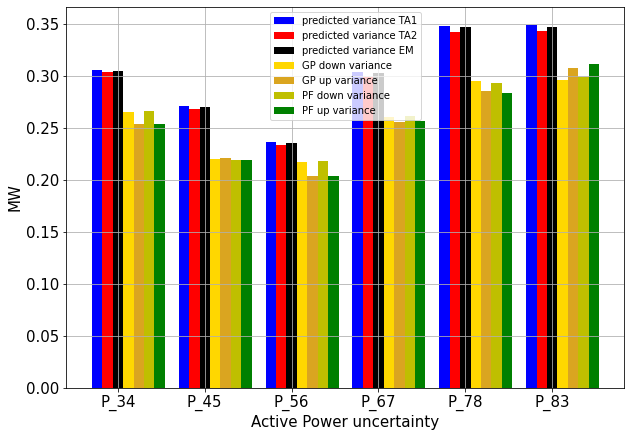

In [26]:
w=0.12
x = ['P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(8,5))

plt.figure(figsize=(10,7))

plt.bar(bar1, pred_uncertanty_TA1[9:15], w, label='predicted variance TA1', color='b')
plt.bar(bar2, pred_uncertanty_TA2[9:15], w, label='predicted variance TA2', color='r')
plt.bar(bar3, pred_uncertanty_EM[9:15], w, label='predicted variance EM', color='k')
plt.bar(bar4, gp_down_uncertanty[9:15], w, label='GP down variance', color='gold')
plt.bar(bar5, gp_up_uncertanty[9:15], w, label='GP up variance', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[9:15], w, label='PF down variance', color='y')
plt.bar(bar7, real_up_uncertanty[9:15], w, label='PF up variance', color='g')


plt.xticks(bar1 + 2*w, x)
plt.ylabel('MW', fontsize=15)
plt.xlabel('Active Power uncertainty', fontsize=15)
plt.legend()
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('figures/P_uncertanty_bar.png', bbox_inches = 'tight')

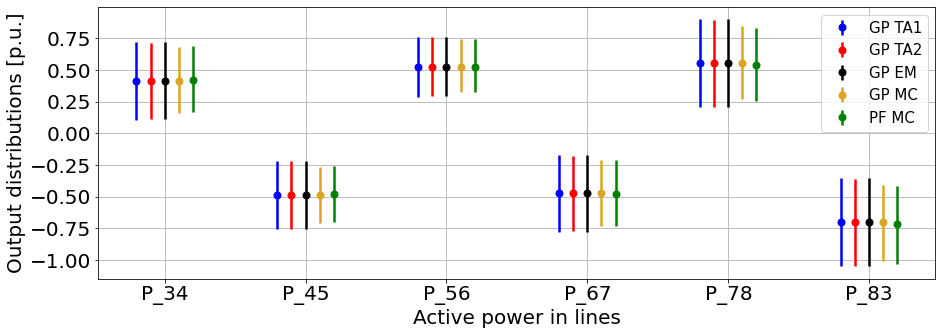

In [27]:
m=6
t = np.arange(1,m+1)-0.2
t1 = np.arange(1,m+1)-0.1
t2 = np.arange(1,m+1)
t3 = np.arange(1,m+1)+0.1
t4 = np.arange(1,m+1)+0.2

plt.figure(figsize=(15, 5))
plt.errorbar(t, x_TA1[:,9:].flatten()/100, yerr= 3 * np.sqrt(s_TA1[:,9:].flatten())/100, marker='.',
                        ms=14, lw=2.5, linestyle='None', color='b', label='GP TA1')
plt.errorbar(t1, x_TA2[:,9:].flatten()/100, yerr= 3 * np.sqrt(s_TA2[:,9:].flatten())/100, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='r', label='GP TA2')
plt.errorbar(t2, x_EM[:,9:].flatten()/100, yerr= 3 * np.sqrt(s_EM[:,9:].flatten())/100, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='k', label='GP EM')

plt.errorbar(t3, out_gp_mean[:, 9:].flatten()/100, yerr=bound_q[:, 9:]/100, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='goldenrod', label='GP MC')
plt.errorbar(t4, out_pf_mean[:, 9:].flatten()/100, yerr=bound[:, 9:]/100, marker='.',
                        ms=14, lw=2.5,linestyle='None', color='g', label='PF MC')


plt.grid()
plt.ylabel('Output distributions [p.u.]', fontsize=20)
plt.xlabel('Active power in lines', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(t2, x, fontsize=20, rotation=0)
plt.yticks(fontsize=20)

plt.savefig('figures/P_uncertanty_error.png', bbox_inches = 'tight')

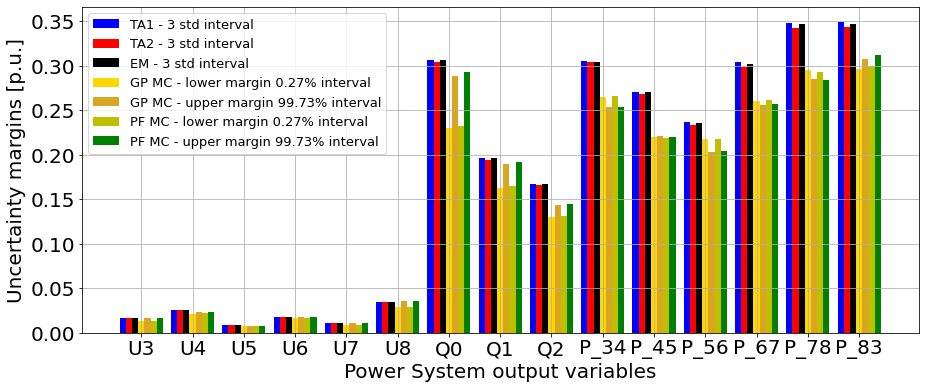

In [28]:
w=0.12
x = ['U3', 'U4', 'U5', 'U6', 'U7', 'U8', 'Q0', 'Q1', 'Q2', 'P_34', 'P_45', 'P_56', 'P_67', 'P_78' , 'P_83']


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(15,6))

plt.bar(bar1, pred_uncertanty_TA1[:15], w, label='TA1 - 3 std interval', color='b')
plt.bar(bar2, pred_uncertanty_TA2[:15], w, label='TA2 - 3 std interval', color='r')
plt.bar(bar3, pred_uncertanty_EM[:15], w, label='EM - 3 std interval', color='k')
plt.bar(bar4, gp_down_uncertanty[:15], w, label='GP MC - lower margin 0.27% interval', color='gold')
plt.bar(bar5, gp_up_uncertanty[:15], w, label='GP MC - upper margin 99.73% interval', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[:15], w, label='PF MC - lower margin 0.27% interval', color='y')
plt.bar(bar7, real_up_uncertanty[:15], w, label='PF MC - upper margin 99.73% interval', color='g')


plt.xticks(bar1 + 2*w + w, x, fontsize=20, rotation=0)
plt.legend(fontsize=13)
plt.ylabel('Uncertainty margins [p.u.]', fontsize=20)
plt.xlabel('Power System output variables', fontsize=20)
plt.grid()
plt.yticks(fontsize=20)

plt.savefig('figures/fig_2.png', bbox_inches = 'tight')

------------------

# Square and Absolute Errors

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [30]:
out_pf_mean_pu = np.zeros((1,15))
x_TA1_pu = np.zeros((1,15))
x_EM_pu = np.zeros((1,15))

out_pf_mean_pu[:,:6] = out_pf_mean[:,:6]/345
out_pf_mean_pu[:,6:] = out_pf_mean[:,6:]/100

x_TA1_pu[:,:6] = x_TA1[:,:6]/345
x_TA1_pu[:,6:] = x_TA1[:,6:]/100

x_EM_pu[:,:6] = x_EM[:,:6]/345
x_EM_pu[:,6:] = x_EM[:,6:]/100

### TA

In [31]:
RMSE_average = mean_squared_error(out_pf_mean_pu.T, x_TA1_pu.T, multioutput='uniform_average', squared=False)
MAE_average = mean_absolute_error(out_pf_mean_pu, x_TA1_pu, multioutput='uniform_average')

RMSE_row = mean_squared_error(out_pf_mean_pu, x_TA1_pu, multioutput='raw_values', squared=False)
MAE_row = mean_absolute_error(out_pf_mean_pu, x_TA1_pu, multioutput='raw_values')

In [32]:
print('RMSE_avrage:', RMSE_average)
print('MAE_average:', MAE_average)

print('')

print('RMSE_row:', RMSE_row)
print('MAE_row:', MAE_row)

RMSE_avrage: 0.006352743795330517
MAE_average: 0.004066590402017042

RMSE_row: [0.00014118 0.0001751  0.00019008 0.00031647 0.00025376 0.00022618
 0.00381279 0.00390573 0.00326288 0.01107149 0.00935409 0.0009994
 0.00101751 0.01121328 0.0150589 ]
MAE_row: [0.00014118 0.0001751  0.00019008 0.00031647 0.00025376 0.00022618
 0.00381279 0.00390573 0.00326288 0.01107149 0.00935409 0.0009994
 0.00101751 0.01121328 0.0150589 ]


### EM

In [33]:
RMSE_average_EM = mean_squared_error(out_pf_mean_pu.T, x_EM_pu.T, multioutput='uniform_average', squared=False)
MAE_average_EM = mean_absolute_error(out_pf_mean_pu, x_EM_pu, multioutput='uniform_average')

RMSE_row_EM = mean_squared_error(out_pf_mean_pu, x_EM_pu, multioutput='raw_values', squared=False)
MAE_row_EM = mean_absolute_error(out_pf_mean_pu, x_EM_pu, multioutput='raw_values')

In [34]:
print('RMSE_avrage:', RMSE_average_EM)
print('MAE_average:', MAE_average_EM)

print('')

print('RMSE_row:', RMSE_row_EM)
print('MAE_row:', MAE_row_EM)

RMSE_avrage: 0.0059503666338624195
MAE_average: 0.003314284561737031

RMSE_row: [1.35135888e-04 1.88099667e-04 6.81812478e-06 3.35608156e-05
 1.11652362e-05 2.49093423e-04 1.32247639e-03 4.42621086e-04
 2.74861380e-04 1.03980706e-02 8.91287715e-03 9.62589807e-04
 9.10245688e-04 1.13349991e-02 1.45316540e-02]
MAE_row: [1.35135888e-04 1.88099667e-04 6.81812478e-06 3.35608156e-05
 1.11652362e-05 2.49093423e-04 1.32247639e-03 4.42621086e-04
 2.74861380e-04 1.03980706e-02 8.91287715e-03 9.62589807e-04
 9.10245688e-04 1.13349991e-02 1.45316540e-02]
